In [1]:
import pickle
import pandas as pd
import polars as pl

import warnings
warnings.filterwarnings('ignore')

from concurrent.futures import ProcessPoolExecutor, as_completed
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys

import numpy as np
import minisom
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
kdprov='32'
print('===============================================')
print('READ THE DATA')
df_training_vh=pd.read_pickle(f'/data/ksa/04_Data_Preprocessing/training-test/32/training_32_VH_recode2_imputation_var10_clusternV2.pkl')
df_training_vh=pl.from_pandas(df_training_vh)
print('FINISH LOAD DATA')

READ THE DATA
FINISH LOAD DATA


In [3]:
df_inner = df_training_vh

In [10]:
ls_col=['idpoint','nth','observation','observation2','periode','idsubsegment','idsegment','cluster_data']

In [11]:
#VV_=[f'VV_{10-i}' for i in range(0,11)]
VH_=[f'VH_{30-i}' for i in range(0,31)]

In [12]:
#ls_col.extend(VV_)
ls_col.extend(VH_)

In [13]:
data_for_som=df_inner.select(ls_col).to_pandas()

In [14]:
data_for_som.observation2.unique()

array([3, 2, 7, 4, 5, 1])

In [ ]:
mapping_dt={
    'V1':1,
    'V2':2,
    'G':3,
    'H':4,
    'BP':5,
    'PL':6,
    'BPL':5,
    'NP':7,
    'NV':7
}

In [ ]:
#data_for_som.observation=data_for_som.observation.apply(lambda y:mapping_dt[y])

In [15]:
data_for_som['observation2']=data_for_som['observation2'].astype(int)
#data_for_som['observation']=data_for_som.observation.apply(lambda y: 7 if y>7 else y)
#data_for_som=data_for_som.query('observation !=6')

In [16]:
data_for_som_frac=data_for_som.groupby(['observation2','cluster_data']).sample(frac=0.7)

<Axes: xlabel='observation2', ylabel='count'>

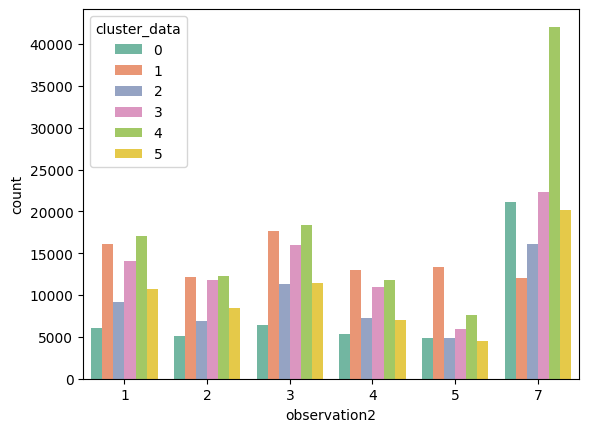

In [17]:
sns.countplot(x='observation2', hue='cluster_data', data=data_for_som_frac,palette=sns.color_palette("Set2"))

In [18]:
## Applying the cluster !
dict_som={}
for i in data_for_som_frac.cluster_data.unique():
    print('Running For Cluster:',i)
    data_som_frac_cl=data_for_som_frac.query('cluster_data==@i')
    means=data_som_frac_cl[VH_].values.mean(axis=1,keepdims=True)
    stds=data_som_frac_cl[VH_].values.std(axis=1,keepdims=True)
    data_som_frac_cl_std=(data_som_frac_cl[VH_]-means)/stds
    print('RUN SOM WITH EUCLIDEANS DISTANCE BASED')
    m_neurons = 20
    n_neurons = 20
    som = minisom.MiniSom(n_neurons, m_neurons, data_som_frac_cl_std.shape[1], sigma=1, 
                      learning_rate=.05, random_seed=1234)
    som.random_weights_init(data_som_frac_cl_std.values)
    som.train_batch(data_som_frac_cl_std.values, 10000, verbose=True) 
    dict_som[str(i)]={'som_model':som}#,'means':means,'stds':stds}

Running For Cluster: 0
RUN SOM WITH EUCLIDEANS DISTANCE BASED
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 3.7737789992828064
Running For Cluster: 1
RUN SOM WITH EUCLIDEANS DISTANCE BASED
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 2.9733831073254002
Running For Cluster: 2
RUN SOM WITH EUCLIDEANS DISTANCE BASED
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 3.752433323882852
Running For Cluster: 3
RUN SOM WITH EUCLIDEANS DISTANCE BASED
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 3.7768793016579307
Running For Cluster: 4
RUN SOM WITH EUCLIDEANS DISTANCE BASED
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 3.921764295820951
Running For Cluster: 5
RUN SOM WITH EUCLIDEANS DISTANCE BASED
 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 3.7874104884052087


In [19]:
print('EXPORT THE RESULTS')
with open(f'//data/ksa/04_Data_Preprocessing/{kdprov}/03_som_filtering/som_training_euclideans_10n_recodeV2.pkl','wb') as file:
    pickle.dump(dict_som,file)

EXPORT THE RESULTS


In [20]:
def som_winner(data,som):
    dummy=np.zeros((1,31))
    data=pd.DataFrame(data,index=[0])
    VH_=data[[f'VH_{30-i}' for i in range(0,31)]].values
    means_VH=np.mean(VH_)
    stds_VH=np.std(VH_)
    dummy=(VH_-means_VH)/stds_VH
    return som.winner(dummy)

In [21]:
print('RUNNING SOM WINNER FOR DATA CLUSTER')
df_data_cl=pd.DataFrame()
for i in data_for_som_frac.cluster_data.unique():
    print('RUNNING CLUSTER:',i)
    data_for_som_cl_pl=pl.from_pandas(data_for_som.query('cluster_data==@i'))
    som_model=dict_som[str(i)]['som_model']
    rows_cl = data_for_som_cl_pl.to_dicts()
    som_rep_list = []
    with ProcessPoolExecutor(max_workers=30) as executor:
        # Submit all tasks to the executor
        futures = [executor.submit(som_winner, row,som_model) for row in rows_cl]
        # Use tqdm to display the progress bar
        for future in tqdm(as_completed(futures), total=len(futures)):
            # Collect the result from each future
            som_rep_list.append(future.result())
    data_for_som_cl_pl = data_for_som_cl_pl.with_columns(pl.Series("som_rep", som_rep_list))
    df_data=data_for_som_cl_pl.to_pandas()
    df_data_cl=pd.concat([df_data_cl,df_data]) 

RUNNING SOM WINNER FOR DATA CLUSTER
RUNNING CLUSTER: 0


100%|██████████| 69975/69975 [00:52<00:00, 1336.69it/s]


RUNNING CLUSTER: 1


100%|██████████| 120375/120375 [01:31<00:00, 1311.66it/s]


RUNNING CLUSTER: 2


100%|██████████| 79550/79550 [01:04<00:00, 1229.34it/s]


RUNNING CLUSTER: 3


100%|██████████| 115700/115700 [01:34<00:00, 1222.96it/s]


RUNNING CLUSTER: 4


100%|██████████| 155925/155925 [02:22<00:00, 1096.29it/s]


RUNNING CLUSTER: 5


100%|██████████| 89325/89325 [02:15<00:00, 661.62it/s] 


In [22]:
df_data_cl['som_rep2']=df_data_cl.som_rep.apply(lambda y:str(f'R{y[0]}C{y[1]}'))
with open(f'//data/ksa/04_Data_Preprocessing/{kdprov}/03_som_filtering/data_winner_10n_recodeV2.pkl',
          'wb') as file:
    pickle.dump(df_data_cl,file)


In [24]:
pivoting=pd.pivot_table(df_data_cl, 
                        columns='observation2',index=['cluster_data','som_rep2'],
                        values='idpoint',aggfunc='count',fill_value=0)

In [25]:
pivoting

observation2             1   2   3   4    5    7
cluster_data som_rep2                           
0            R0C0        7  10   4   4   24  203
             R0C1       36  18  11   3    5   62
             R0C10       1   0   1   1    2   30
             R0C11      15   3   4   2    4   96
             R0C12       6  16   2   3    4   55
...                    ...  ..  ..  ..  ...  ...
5            R9C5        6   0   4   2    1   18
             R9C6      113   6   4  22  191  101
             R9C7       98   0   0   0    1    7
             R9C8      146   4   1   1    4    8
             R9C9      187   7   2   0    7   17

[2397 rows x 6 columns]

In [26]:
def get_neighbors(som, neuron, radius=1.5):
    weights_shape = som.get_weights().shape  # Get the shape of the SOM grid
    x, y = neuron
    neighbors = []
    for i in range(weights_shape[0]):  # Iterate over x dimension
        for j in range(weights_shape[1]):  # Iterate over y dimension
            distance = np.sqrt((x - i) ** 2 + (y - j) ** 2)
            if (distance <= radius)and(distance>0):
                neighbors.append((i, j))
    return neighbors

In [29]:
dict_prior_posterior={}
for k in tqdm(pivoting.reset_index().cluster_data.unique()):
    dict_prior_posterior[f'CL{k}']={}
    for i in range(0,20):
        for j in range(0,20):
            id=f'R{i}C{j}'
            dict_prior_posterior[f'CL{k}'][id]={}
            if id in pivoting.reset_index().query('cluster_data==@k').som_rep2.unique():
                u=pivoting.reset_index().query('cluster_data==@k').query('som_rep2==@id')[[1,2,3,4,5,7]].values
                dict_prior_posterior[f'CL{k}'][id]['ndata']=u
                sum_=np.sum(u)
                dict_prior_posterior[f'CL{k}'][id]['sum']=sum_
                dict_prior_posterior[f'CL{k}'][id]['prior']=u/sum_
            else:
                dict_prior_posterior[f'CL{k}'][id]['ndata']=[[0,0,0,0,0,0]]
                dict_prior_posterior[f'CL{k}'][id]['sum']=0
                dict_prior_posterior[f'CL{k}'][id]['prior']=[[0,0,0,0,0,0]]
            som=dict_som[str(k)]['som_model']
            dict_prior_posterior[f'CL{k}'][id]['neighbor']=get_neighbors(som,(i,j))

100%|██████████| 6/6 [00:23<00:00,  3.96s/it]


In [31]:
for k in pivoting.reset_index().cluster_data.unique():
    for i in dict_prior_posterior[f'CL{k}'].keys():
        sigma2j=np.abs(0.9999-np.max(dict_prior_posterior[f'CL{k}'][i]['prior']))
        #print(dict_prior_posterior[i]['prior'])
        list_mjk=np.zeros(6)
        for j in dict_prior_posterior[f'CL{k}'][i]['neighbor']:
            list_mjk=list_mjk+dict_prior_posterior[f'CL{k}'][f'R{j[0]}C{j[1]}']['prior']
        j=dict_prior_posterior[f'CL{k}'][i]['neighbor']
        list_mjk=list_mjk/len(j)
        list_s2jk=np.square(dict_prior_posterior[f'CL{k}'][i]['prior']-list_mjk)/(len(j)-1)
        list_posterior_left=((list_s2jk/(sigma2j+list_s2jk))*(dict_prior_posterior[f'CL{k}'][i]['prior']))
        list_posterior_right=((sigma2j/(sigma2j+list_s2jk))*(list_mjk))
        list_posterior=list_posterior_left+list_posterior_right
        dict_prior_posterior[f'CL{k}'][i]['posterior']=list_posterior

In [32]:
dict_prior_posterior.keys()

dict_keys(['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5'])

In [33]:
dt=pd.DataFrame()
for i in dict_prior_posterior.keys():
    temp=pd.DataFrame(dict_prior_posterior[i]).T.reset_index()
    temp['cluster_data']=int(i.replace('CL',''))
    temp['prior_optimal']=0
    temp['posterior_optimal']=0
    temp['observation_optimal']=0
    temp['ndata_optimal']=0
    for index, rows in temp.iterrows():
        label=[1,2,3,4,5,7]
        prior=rows['prior'][0]
        ndata=rows['ndata'][0]
        posterior=rows['posterior'][0]
        idx=np.argmax(prior)
        temp.at[index, 'observation_optimal']=label[idx]
        temp.at[index,'ndata_optimal']=ndata[idx]
        temp.at[index,'prior_optimal']=prior[idx]
        temp.at[index,'posterior_optimal']=posterior[idx]
    dt=pd.concat([temp,dt])

In [35]:
dx=dt.query('prior_optimal>=0.4')#.query('posterior_optimal>0.3')
dx.pivot_table(index='cluster_data',columns='observation_optimal',values='index',aggfunc='count').fillna(0)

observation_optimal,1,2,3,4,5,7
cluster_data,,,,,,
0,78.0,18.0,13.0,7.0,11.0,246.0
1,127.0,61.0,38.0,16.0,35.0,82.0
2,96.0,25.0,34.0,22.0,6.0,143.0
3,78.0,29.0,26.0,10.0,0.0,166.0
4,64.0,19.0,18.0,7.0,0.0,240.0
5,66.0,28.0,21.0,10.0,2.0,213.0


In [36]:
df_data_cl

,idpoint,nth,observation,observation2,periode,idsubsegment,idsegment,cluster_data,VH_30,VH_29,...,VH_7,VH_6,VH_5,VH_4,VH_3,VH_2,VH_1,VH_0,som_rep,som_rep2
0,320130009A2#01,1,NV,7,2022_03,320130009A2,320130009,0,-14.148290,-14.472591,...,-11.953610,-11.514040,-12.289023,-13.312219,-13.094807,-12.889192,-14.132917,-14.075207,"[6, 17]",R6C17
1,320130009A2#02,1,NV,7,2022_03,320130009A2,320130009,0,-14.095118,-13.584288,...,-14.224901,-14.848015,-14.677764,-14.589343,-14.547180,-14.498719,-14.043471,-13.636328,"[15, 4]",R15C4
2,320130009A2#03,1,NV,7,2022_03,320130009A2,320130009,0,-13.140158,-12.839005,...,-13.852142,-16.004354,-14.023123,-12.439571,-13.092879,-13.028826,-13.622952,-13.137141,"[18, 13]",R18C13
3,320130009A2#04,1,NV,7,2022_03,320130009A2,320130009,0,-13.046235,-12.916260,...,-13.803753,-15.473886,-13.748962,-12.255089,-13.686076,-14.318362,-15.290305,-14.152237,"[15, 2]",R15C2
4,320130009A2#05,1,NV,7,2022_03,320130009A2,320130009,0,-13.678235,-14.909187,...,-14.978036,-15.218637,-14.984811,-14.690113,-15.037619,-15.290932,-15.098521,-15.036708,"[18, 2]",R18C2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89320,321115006C2#21,9,BP,7,2023_23,321115006C2,321115006,5,-13.940200,-14.457476,...,-17.018524,-17.139059,-17.710989,-18.103237,-19.254705,-18.771636,-18.282820,-18.772762,"[1, 16]",R1C16
89321,321115006C2#22,9,BP,7,2023_23,321115006C2,321115006,5,-14.950670,-14.474518,...,-16.810282,-18.303194,-18.317939,-18.542667,-19.227545,-18.395543,-17.297997,-18.690413,"[12, 6]",R12C6
89322,321115006C2#23,9,BP,7,2023_23,321115006C2,321115006,5,-14.478335,-13.786831,...,-16.192176,-17.175316,-17.913799,-19.182514,-18.471285,-18.760375,-18.622524,-18.851101,"[1, 9]",R1C9
89323,321115006C2#24,9,BP,7,2023_23,321115006C2,321115006,5,-14.171864,-14.301985,...,-16.679360,-17.344173,-17.722958,-18.246319,-18.867735,-19.100588,-19.253292,-19.583492,"[1, 7]",R1C7


In [38]:
df_data_cl_pandas = df_data_cl#.to_pandas()

# Pre-define np_dt list
np_dt = [1,2,3,4,5,7]

# Initialize new columns in the pandas DataFrame
df_data_cl_pandas['prior'] = 0
df_data_cl_pandas['posterior'] = 0
df_data_cl_pandas['sum'] = 0

# Iterate through the DataFrame with tqdm for progress monitoring
for index, row in tqdm(df_data_cl_pandas.iterrows(), total=df_data_cl_pandas.shape[0]):
    rows_neuron = row['som_rep2']
    observation = row['observation2']
    idx = np_dt.index(observation)
    cluster_data = 'CL' + str(row['cluster_data'])
    
    # Look up values from the dictionary
    prior = dict_prior_posterior[cluster_data][rows_neuron]['prior'][0][idx]
    posterior = dict_prior_posterior[cluster_data][rows_neuron]['posterior'][0][idx]
    sum_val = dict_prior_posterior[cluster_data][rows_neuron]['sum']
    
    # Assign the values to the pandas DataFrame
    df_data_cl_pandas.at[index, 'prior'] = prior
    df_data_cl_pandas.at[index, 'posterior'] = posterior
    df_data_cl_pandas.at[index, 'sum'] = sum_val

100%|██████████| 630850/630850 [44:54<00:00, 234.13it/s]  


In [39]:
df_data_cl_pandas.head(2)

,idpoint,nth,observation,observation2,periode,idsubsegment,idsegment,cluster_data,VH_30,VH_29,...,VH_4,VH_3,VH_2,VH_1,VH_0,som_rep,som_rep2,prior,posterior,sum
0,320130009A2#01,1,NV,7,2022_03,320130009A2,320130009,0,-14.148290,-14.472591,...,-13.312219,-13.094807,-12.889192,-14.132917,-14.075207,"[6, 17]",R6C17,0.020906,0.097608,287
1,320130009A2#02,1,NV,7,2022_03,320130009A2,320130009,0,-14.095118,-13.584288,...,-14.589343,-14.547180,-14.498719,-14.043471,-13.636328,"[15, 4]",R15C4,0.083591,0.255812,323


In [40]:
print('EXPORT THE RESULTS')
with open(f'//data/ksa/04_Data_Preprocessing/{kdprov}/03_som_filtering/data_with_prior_posterior_10_recode2.pkl','wb') as file:
    pickle.dump(df_data_cl_pandas,file)

EXPORT THE RESULTS


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
for i in df_data_cl_pandas.cluster_data.unique():
    print('Cluster ',i)
    # Create a figure with 2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(7,2))
    temp=df_data_cl_pandas.query('cluster_data==@i')
    sns.histplot(temp['prior'], bins=30, kde=False, color='blue', edgecolor='black',cumulative=False,ax=axs[0])
    sns.histplot(temp['prior'], bins=30, kde=False, color='blue', edgecolor='black',cumulative=True,ax=axs[1])
    axs[0].set_xlim(0,1)
    axs[1].set_xlim(0,1)    
    axs[0].axvline(x=0.4,color='red', linestyle='--', linewidth=2)
    axs[0].axvline(x=0.5,color='green', linestyle='--', linewidth=2)
    plt.tight_layout()
    plt.show()

In [ ]:
for i in df_data_cl_pandas.cluster_data.unique():
    print('Cluster ',i)
    # Create a figure with 2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(7,2))
    temp=df_data_cl_pandas.query('cluster_data==@i')
    sns.histplot(temp['posterior'], bins=30, kde=False, color='blue', edgecolor='black',cumulative=False,ax=axs[0])
    sns.histplot(temp['posterior'], bins=30, kde=False, color='blue', edgecolor='black',cumulative=True,ax=axs[1])
    axs[0].set_xlim(0,1)
    axs[1].set_xlim(0,1)
    axs[0].axvline(x=0.4,color='red', linestyle='--', linewidth=2)
    axs[0].axvline(x=0.5,color='green', linestyle='--', linewidth=2)
    plt.tight_layout()
    plt.show()

In [ ]:
for i in df_data_cl_pandas.cluster_data.unique():
    print('Cluster ',i)
    temp=df_data_cl_pandas.query('cluster_data==@i')
    plt.figure(figsize=(3, 3)) 
    plt.hexbin(temp['prior'], temp['posterior'], gridsize=20, cmap='Blues')
    plt.colorbar(label='Counts')
    plt.xlabel('Prior')
    plt.ylabel('Posterior')
    plt.title('Hexbin Plot with Bin Size of 30')
    plt.axvline(x=0.2,color='red', linestyle='--', linewidth=2)
    plt.axvline(x=0.25,color='green', linestyle='--', linewidth=2)
    plt.axhline(y=0.2,color='red', linestyle='--', linewidth=2)
    plt.axhline(y=0.25,color='green', linestyle='--', linewidth=2)
    plt.show()

0


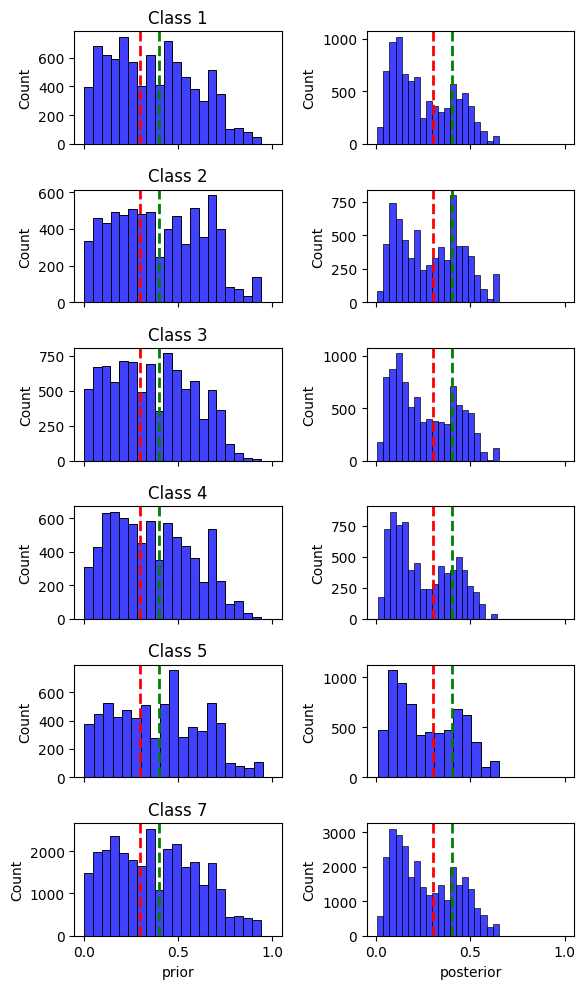

1


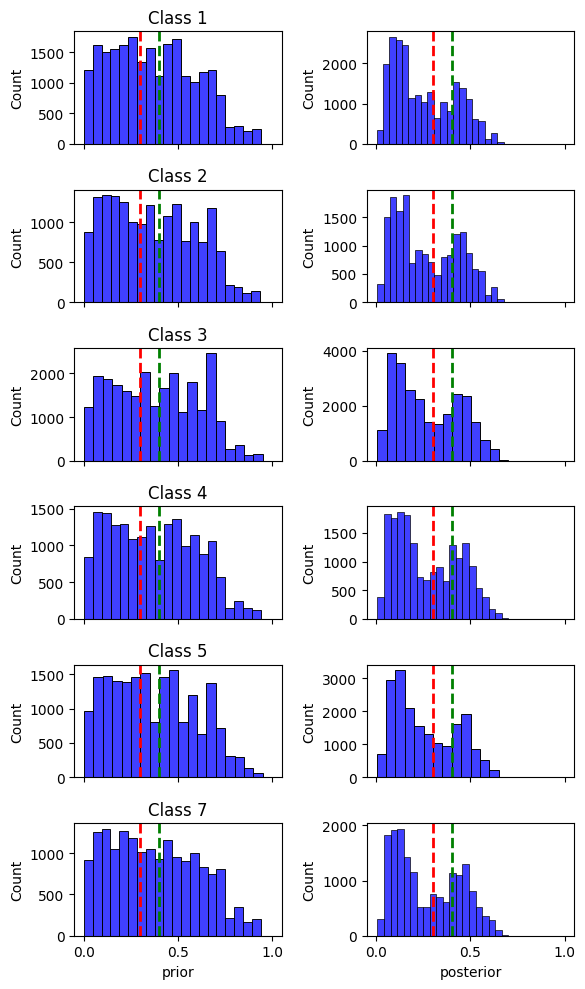

2


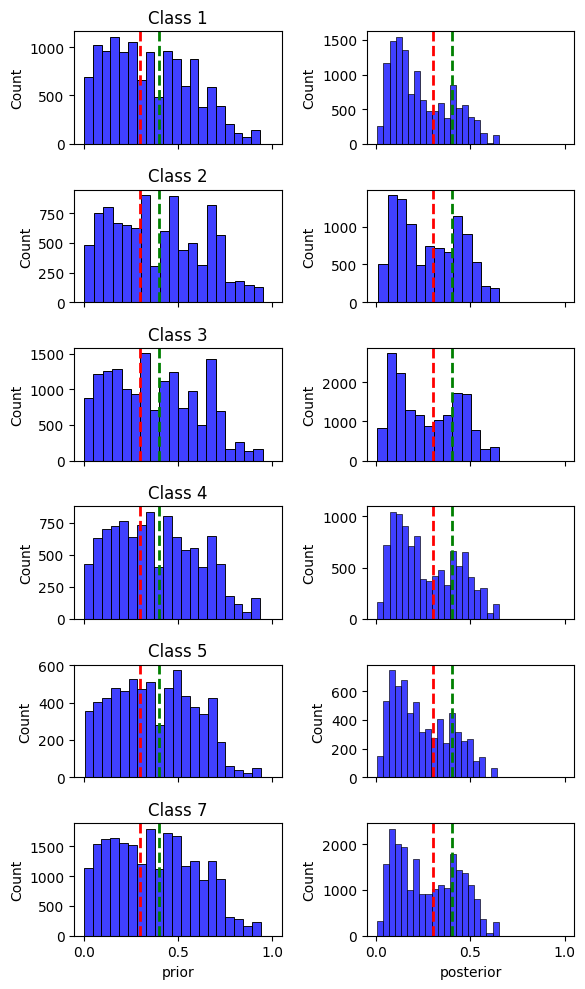

3


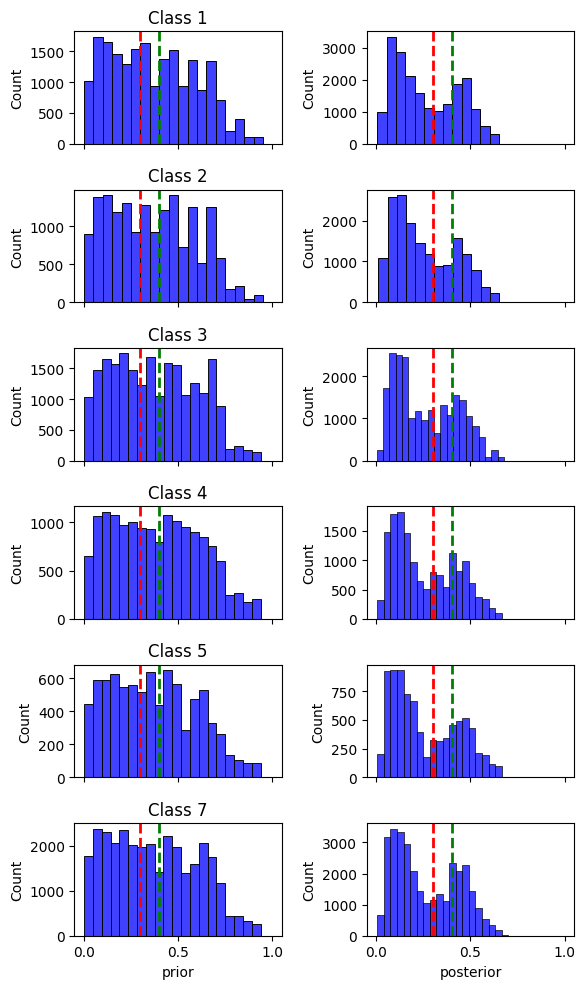

4


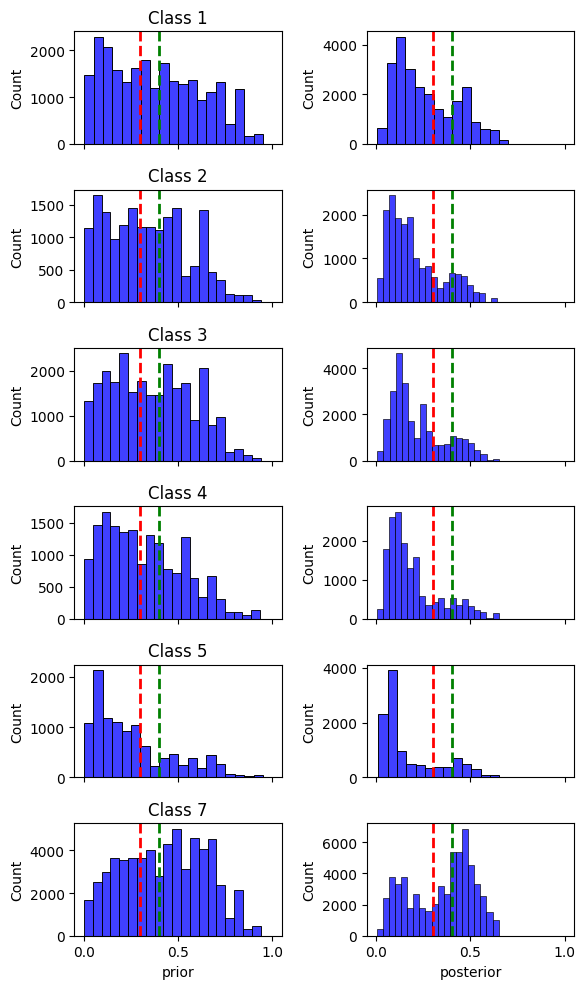

5


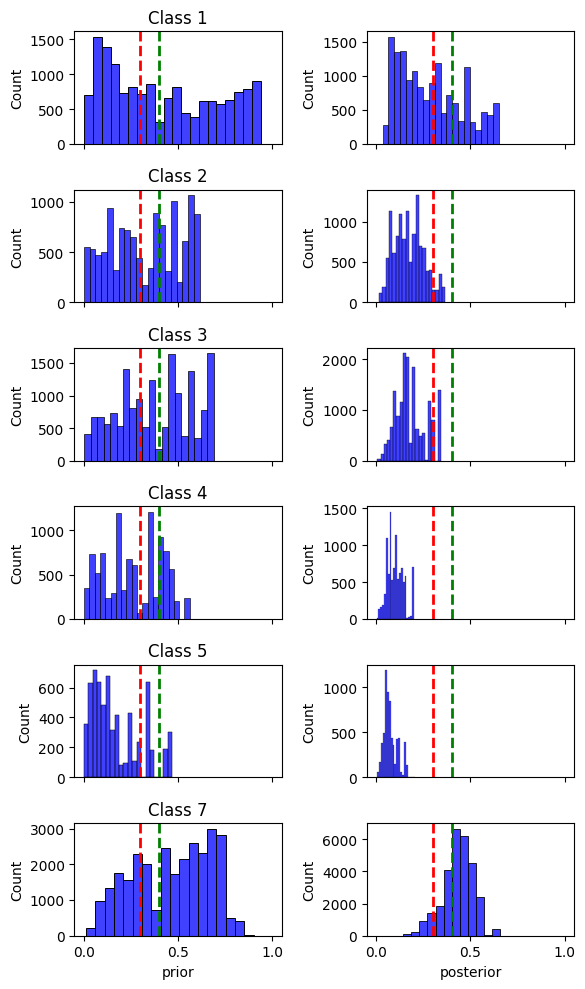

In [42]:
observation=[1,2,3,4,5,7]
for i in df_data_cl_pandas.cluster_data.unique():
    fig, axs = plt.subplots(6, 2, figsize=(6, 10),sharex=True)
    j=0
    print(i)
    temp=df_data_cl_pandas.query('cluster_data==@i')
    for k in observation:
        df_data_slice=temp.query('observation2==@k')
        sns.histplot(df_data_slice['prior'], bins=20, kde=False, color='blue', edgecolor='black',ax=axs[j][0])
        sns.histplot(df_data_slice['posterior'], bins=20, kde=False, color='blue', edgecolor='black',ax=axs[j][1])
        axs[j][0].set_title(f'Class {k}')
        axs[j][0].axvline(x=0.3,color='red', linestyle='--', linewidth=2)
        axs[j][0].axvline(x=0.4,color='green', linestyle='--', linewidth=2)
        axs[j][1].axvline(x=0.3,color='red', linestyle='--', linewidth=2)
        axs[j][1].axvline(x=0.4,color='green', linestyle='--', linewidth=2)
        j+=1
    plt.tight_layout()
    plt.show()